In [1]:
using LinearAlgebra

In [30]:
struct Boundary
    boundtype :: Symbol
    vertice_start :: Int64
    vertice_end :: Int64
    node_num :: Int64
    bias:: Float64
    
    function Boundary(boundtype::Symbol, vertice_start::Int64, vertice_end::Int64, node_num::Int64, bias::Float64=1.0)
        new(boundtype, vertice_start, vertice_end, node_num, bias)
    end
end

struct MeshDef
    blocks :: Vector{Dict{Symbol, Any}}
    bounds :: Vector{Boundary}
    vertices :: Vector{Vector{Float64}}
end

function emptyMeshDef()
    blocks = Vector{Dict{Symbol,Any}}()
    bounds = Vector{Boundary}()
    vertices = Vector{Vector{Float64}}()
    
    MeshDef(blocks, bounds, vertices)
end

function addVertice(meshdef::MeshDef, coordinates::Vector{Float64})
    push!(meshdef.vertices, coordinates)
    
    return size(meshdef.vertices, 1)
end

struct BoundaryLink
    id :: Int64
    vert_start :: Int64
    vert_end :: Int64
end

function extrude(meshdef::MeshDef, vert_start::Int64, direction::Vector{Float64}, length::Float64, node_num::Int64, bias::Float64=0.0)
    dir_norm = direction/norm(direction)
    
    coords_start = meshdef.vertices[vert_start]
    coords_new = coords_start + dir_norm * length
    
    vert_end = addVertice(meshdef, coords_new)
    
    bound_tmp = Boundary(:straight, vert_start, vert_end, node_num, bias)
    
    push!(meshdef.bounds, bound_tmp)
    
    bound_id = size(meshdef.bounds, 1)
    
    return BoundaryLink(bound_id, vert_start, vert_end)
end

function connect(meshdef::MeshDef, vert_start::Int64, vert_end::Int64, node_num::Int64, bias::Float64=0.0)
    
    push!(meshdef.bounds, Boundary(:straight, vert_start, vert_end, node_num, bias))
    
    bound_id = size(meshdef.bounds, 1)
    
    return BoundaryLink(bound_id, vert_start, vert_end)
end

function extrude(meshdef::MeshDef, boundlink::BoundaryLink, direction::Vector{Float64}, length::Float64, node_num::Int64, bias::Float64=0.0)
    
    bounds = Vector{Int64}()
    
    boundlink1 = extrude(meshdef, boundlink.vert_start, direction, length, node_num, bias)
    
    boundlink2 = extrude(meshdef, boundlink.vert_end, direction, length, node_num, bias)
    
    startbound = meshdef.bounds[boundlink.id]
    
    boundlink3 = connect(meshdef, boundlink2.vert_end, boundlink1.vert_end, startbound.node_num, 1/startbound.bias)
    
    bounds = [boundlink.id, boundlink1.id, boundlink3.id, -boundlink2.id]
    
    blockdef = Dict(:type=>:transfinite, :bounds=>bounds)
    
    push!(meshdef.blocks, blockdef)
end

extrude (generic function with 4 methods)

In [31]:
meshdef = emptyMeshDef()

vert = addVertice(meshdef, [0.0, 0.0])

boundlink = extrude(meshdef, vert, [1.0, 0.0, ], 1.5, 10, 2.0)

extrude(meshdef, boundlink, [0.0, 1.0], 1.5, 10, 3.0)

meshdef

size(meshdef.vertices, 1)

4

In [32]:
meshdef

MeshDef(Dict{Symbol,Any}[Dict(:type=>:transfinite,:bounds=>[1, 2, 4, -3])], Boundary[Boundary(:straight, 1, 2, 10, 2.0), Boundary(:straight, 1, 3, 10, 3.0), Boundary(:straight, 2, 4, 10, 3.0), Boundary(:straight, 4, 3, 10, 0.5)], Array{Float64,1}[[0.0, 0.0], [1.5, 0.0], [0.0, 1.5], [1.5, 1.5]])

In [21]:
using Plots

import Base.show

function show!(p::Plots.Plot, boundary::Boundary, meshdef::MeshDef)
    vert_start = boundary.vertice_start
    vert_end = boundary.vertice_end
    coords = meshdef.vertices[[vert_start, vert_end]]

    plot!(p, [coords[1][1], coords[2][1]], [coords[1][2], coords[2][2]], linecolor="blue")
end

function show!(p::Plots.Plot, vertice::Vector{Float64})
    scatter!(p, [vertice[1]], [vertice[2]], marker=(:circle, :red, 6))
end

function show!(p::Plots.Plot, mesh::Mesh)
    
    for node in mesh.nodes
        scatter!(p, [node[1]], [node[2]], marker=(:circle, :blue, 3))
    end
end

function show(meshdef::MeshDef)
    p = plot(legend=false)
    
    for boundary in meshdef.bounds
        show!(p, boundary, meshdef)
    end
    
    mesh = emptyMesh()
    generateBoundaryMesh!(mesh, meshdef)
    show!(p, mesh)
    
    for vertice in meshdef.vertices
        show!(p, vertice)
    end
    
    p
end

show (generic function with 378 methods)

In [2]:
function defineCartesian(xmin::Float64, ymin::Float64, xmax::Float64, ymax::Float64, nx::Int64, ny::Int64)
    # Create vertices
    vertices = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    
    # Create Bounds
    bounds = Vector{Boundary}(undef, 4)
    for i in 1:4
        n = i in (1,3) ? nx : ny
        bounds[i] = Boundary(:equidistant, i, i%4+1, n)
    end

    blocks = [Dict(:type=>:cartesian, :bounds=>[1,2,3,4])]
        
    return MeshDef(blocks, bounds, vertices)
end

defineCartesian (generic function with 1 method)

In [6]:
mutable struct Mesh
    nodes :: Vector{Vector{Float64}}
    elements :: Vector{Vector{Int64}}
end

function emptyMesh()
    Mesh(Vector{Float64}[], Vector{Int64}[])
end

function generateBoundaryMesh!(mesh::Mesh, meshdefinition::MeshDef)
    # create Dict for Node mapping, mapping of node_ids to boundary respectiveley vertice ids
    nodeMapping = Dict(:vertice => Dict{Int64, Int64}(), :boundary => Dict{Int64, Vector{Int64}}())
    
    # create nodes on bounds
    for (boundary_id, boundary) in enumerate(meshdefinition.bounds)
        
        # when first or last node (at vertex) is already created with other boundary -> skip
        skipFirst = skipLast = false
        if verthasNode(nodeMapping, boundary.vertice_start)
            skipFirst = true
        end
        
        if verthasNode(nodeMapping, boundary.vertice_end)
            skipLast = true
        end
        
        # create Boundary Notes and append them to mesh
        node_ids = appendBoundaryNodes!(mesh, boundary, meshdefinition.vertices, skipFirst, skipLast)
        
        nodeMapping[:boundary][boundary_id] = node_ids
        
        # add created nodes to nodeMapping
        if !skipFirst
            nodeMapping[:vertice][boundary.vertice_start] = node_ids[1]
        else
            insert!(nodeMapping[:boundary][boundary_id], 1, nodeMapping[:vertice][boundary.vertice_start])
        end
        if !skipLast
            nodeMapping[:vertice][boundary.vertice_end] = node_ids[end]
        else
            push!(nodeMapping[:boundary][boundary_id], nodeMapping[:vertice][boundary.vertice_end])
        end
    end
            
    return nodeMapping
end

function generateMesh(meshdefinition::MeshDef)
    
    # disable garbage collection during mesh creation
    GC.enable(false)
    
    # create an empty Mesh object
    mesh = emptyMesh()
    
    
    nodeMapping = generateBoundaryMesh!(mesh, meshdefinition)
    
    
    # generate blocks
    for (block_id, block) in enumerate(meshdefinition.blocks)
                
        block_bounds = [meshdef.bounds[abs(i)] for i in block[:bounds]]
                
        addBlock!(mesh, block, block_bounds, nodeMapping)
    end
    
    GC.enable(true)
            
    return mesh
end

function verthasNode(nodeMapping, vert_id)
    return haskey(nodeMapping[:vertice], vert_id)
end

verthasNode (generic function with 1 method)

In [7]:
function getBoundaryNodeIds(bound_id, nodeMapping)
    boundarynodes = nodeMapping[:boundary][abs(bound_id)]
    
    if bound_id > 0
        return boundarynodes
    else
            return boundarynodes[end:-1:1]
    end
end

function addBlock!(mesh::Mesh, block, bounds, nodeMapping)
    if !(block[:type] == :cartesian)
        throw(DomainError())
    end
    
    # extract blocks boundaries
    boundary_ids = block[:bounds]
    boundaries = bounds[boundary_ids]
    
    # number of nodes in directions 1 (bound1, -bound3)
    #   and 2 (bound2, -bound4)
    n1 = boundaries[1].node_num
    n2 = boundaries[2].node_num
    # TODO: check other bounds, throw Exception
    
    # get boundary nodes for first boundary from nodeMapping
    node_ids = getBoundaryNodeIds(boundary_ids[1], nodeMapping)
    
    # coords of second bound
    coords = mesh.nodes[getBoundaryNodeIds(boundary_ids[2], nodeMapping)]
    
    # iterate over second dimension of block
    for i in 2:n2
        
        # store recent nodes
        last_node_ids = node_ids
        
        # generate next nodes
        if i<n2
            # calculate translation
            translation = coords[i]-coords[i-1]

            # copy nodes
            new_node_ids = translateNodes!(mesh, node_ids[2:end-1], translation, copynodes=true)
            
            node_ids = [getBoundaryNodeIds(boundary_ids[4], nodeMapping)[end-(i-1)],
                        new_node_ids..., 
                        getBoundaryNodeIds(boundary_ids[2], nodeMapping)[i]] 
        else
            node_ids = nodeMapping[:boundary][boundary_ids[3]][end:-1:1]
        end
            
        for j in 2:n1
            # create Elements
                
            el_node1 = last_node_ids[j-1]
            el_node2 = last_node_ids[j]
            el_node3 = node_ids[j]
            el_node4 = node_ids[j-1]
            
            el_nodes = [el_node1, el_node2, el_node3, el_node4]
            
            el_id = appendElement!(mesh, el_nodes)
        end
    end
end

function translateNodes!(mesh::Mesh, node_ids::Vector{Int64}, translation::Vector{Float64}; copynodes::Bool=true)
    if !copynodes
        throw(DomainError())
    end
    
    coords = []
        
    for node_id in node_ids
        push!(coords, mesh.nodes[node_id]+translation)
    end
            
    node_ids_new = appendNodes!(mesh, coords)
    
    return node_ids_new
end

translateNodes! (generic function with 1 method)

In [8]:
function appendNodes!(mesh::Mesh, nodecoords)
    start_id = size(mesh.nodes, 1)+1
    length = size(nodecoords, 1)
    
    append!(mesh.nodes, nodecoords)
    
    return collect(start_id:1:start_id+length-1)
end

function appendElement!(mesh::Mesh, node_ids)
    push!(mesh.elements, node_ids)
end

appendElement! (generic function with 1 method)

In [9]:
function appendBoundaryNodes!(mesh::Mesh, boundary::Boundary, vertices, skipFirst::Bool, skipLast::Bool)
    if boundary.boundtype != :straight
        throw(DomainError())
    end
    
    # get coordinates of start and end point
    coords1 = vertices[boundary.vertice_start]
    coords2 = vertices[boundary.vertice_end]

    # linear interpolation to get all coordinates    
    Δcoords = coords2-coords1
    n = boundary.bias
    us = collect(range(0, length=boundary.node_num, stop=1 ))
    nodes = [coords1 + Δcoords * u^n for u in us]
    
    #
    id1 = skipFirst ? 2 : 1
    id2 = skipLast ? 1 : 0
    
    nodeids = appendNodes!(mesh, nodes[id1:end-id2])
    
    return nodeids
end

appendBoundaryNodes! (generic function with 1 method)

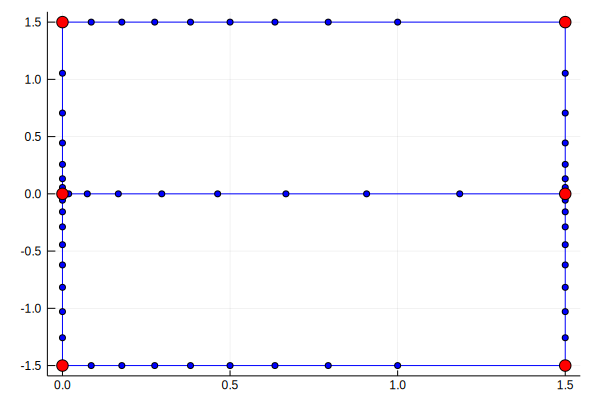

In [34]:
meshdef = emptyMeshDef()

vert = addVertice(meshdef, [0.0, 0.0])

boundlink = extrude(meshdef, vert, [1.0, 0.0, ], 1.5, 10, 2.0)

extrude(meshdef, boundlink, [0.0, 1.0], 1.5, 10, 3.0)
extrude(meshdef, boundlink, [0.0, -1.0], 1.5, 10, 1.5)

meshdef

size(meshdef.vertices, 1)

show(meshdef)

In [43]:
using Formatting

function writeAbq(filename::String, mesh::Mesh)
    # open file
    open(filename, "w") do afile
        # node header
        write(afile, "*Node\n")
        
        # node coordinates
        for (nodeid, nodecoords) in enumerate(mesh.nodes)
            write(afile, format("{}, {}, {}\n", nodeid, nodecoords...))
        end
        
        # element header
        write(afile, "*Element, type=CPS4R\n")
        
        # elements
        for (elid, element) in enumerate(mesh.elements)
            write(afile, format("{}, {}, {}, {}, {}\n", elid, element...))
        end
    end
end

writeAbq (generic function with 1 method)

In [44]:
#meshdef = defineCartesian(0.0, 0.0, 1.0, 10.0, 1000, 500)

@time mesh = generateMesh(meshdef);

MethodError: MethodError: no method matching DomainError()
Closest candidates are:
  DomainError(!Matched::Any) at boot.jl:256
  DomainError(!Matched::Any, !Matched::Any) at boot.jl:257

In [170]:
writeAbq("test.inp", mesh)

In [171]:
varinfo()

| name                 |       size | summary                      |
|:-------------------- | ----------:|:---------------------------- |
| Base                 |            | Module                       |
| Boundary             |  212 bytes | DataType                     |
| Core                 |            | Module                       |
| Main                 |            | Module                       |
| Mesh                 |  196 bytes | DataType                     |
| MeshDef              |  204 bytes | DataType                     |
| a                    |   72 bytes | 4-element Array{Int64,1}     |
| addBlock!            |    0 bytes | typeof(addBlock!)            |
| addElement!          |    0 bytes | typeof(addElement!)          |
| appendBoundaryNodes! |    0 bytes | typeof(appendBoundaryNodes!) |
| appendElement!       |    0 bytes | typeof(appendElement!)       |
| appendNodes!         |    0 bytes | typeof(appendNodes!)         |
| defineCartesian      |    0 bytes | typeof(defineCartesian)      |
| emptyMesh            |    0 bytes | typeof(emptyMesh)            |
| generateMesh         |    0 bytes | typeof(generateMesh)         |
| mesh                 | 20.538 MiB | Mesh                         |
| meshdef              |  1.070 KiB | MeshDef                      |
| startupfile          |   50 bytes | String                       |
| translateNodes!      |    0 bytes | typeof(translateNodes!)      |
| verthasNode          |    0 bytes | typeof(verthasNode)          |
| writeAbq             |    0 bytes | typeof(writeAbq)             |


In [15]:
show!(meshdef)

MethodError: MethodError: no method matching show!(::MeshDef)
Closest candidates are:
  show!(!Matched::Plots.Plot, !Matched::Boundary, !Matched::MeshDef) at In[14]:6
  show!(!Matched::Plots.Plot, !Matched::Array{Float64,1}) at In[14]:14
  show!(!Matched::Plots.Plot, !Matched::Mesh) at In[14]:19